## Introduction
From Kaggle open resource, we had **training** dataset, **public test** dataset (which is then used as validation dataset for our project), and further a **private test** dataset (same size with public test dataset and will be used as data for evaluating the prediction performance).

Image set of 35,887 examples, with training-set : **80%** validation-set : **10%** test-set : **10%**.

## Objectives
(i) To apply Convolutional neural networks (CNN) for facial expression recognition.
 
(ii) To correctly classify each facial image into one of the seven facial emotion categories: **anger**, **disgust**, **fear**, **happiness**, **sadness**, **surprise**, and **neutral**.


---------------------------------------------------------------------------------------
## Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras import models
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input"))

Using TensorFlow backend.


['fer2013.csv']


## Dataset Overview

In [2]:
data = pd.read_csv('../input/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [3]:
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [5]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


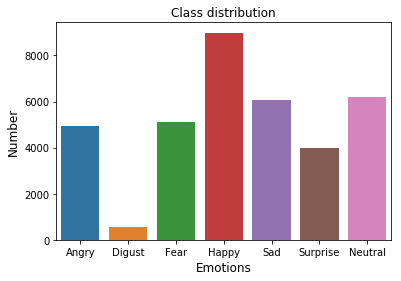

In [6]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

#### Let's look at some images...

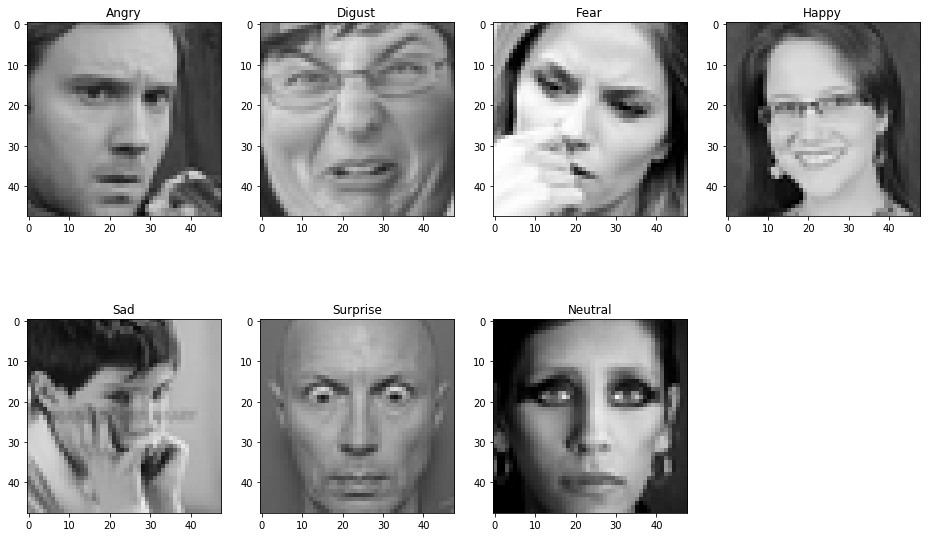

In [7]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

----------------------------------------------------------------------------------
## Pre-processing data
#### Summary:
1. Splitting dataset into 3 parts: train, validation, test
1. Convert strings to lists of integers
1. Reshape to 48x48 and normalise grayscale image with 255.0
1. Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [8]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


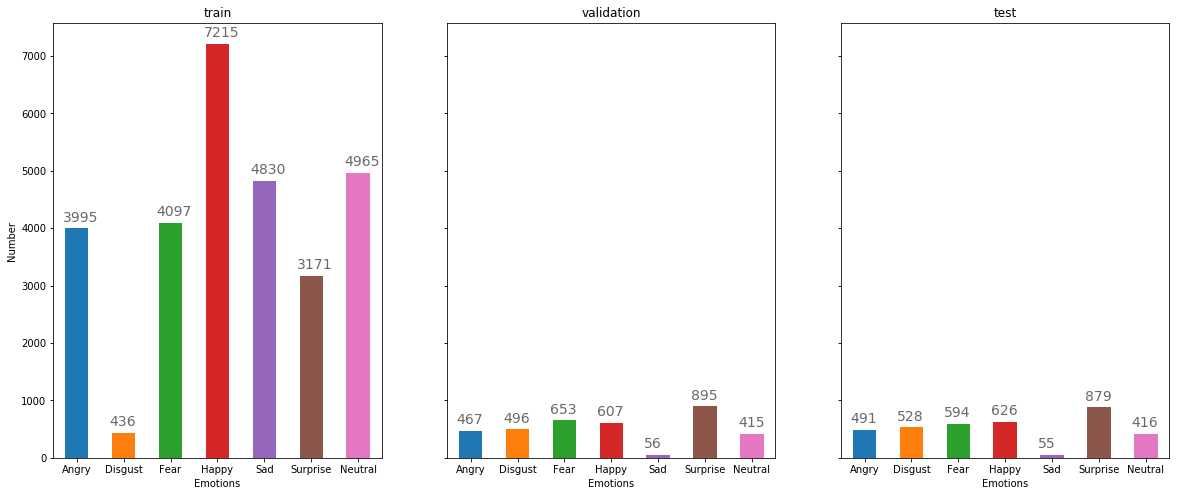

In [9]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

Notice that the later two subplots share the same y-axis with the first subplot. 

The size of **train**, **validation**, **test** are **80%**, **10%** and **10%**, respectively. 

The exact number of each class of these datasets are written on top of their x-axis bar. 

In [10]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [11]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


----------------------------------------------------------------------------------
## Building CNN Model

### CNN Architecture:  
* Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling 
* Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling 
* Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling 
* Flatten
* Dense -> BN -> Activation
* Dense -> BN -> Activation
* Dense -> BN -> Activation
* Output layer

In [12]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 256)       0         
__________

In [13]:
num_classes = 7

# Apply batchnormalization before activation function
# He normal initialization works best on layers w/ ReLU activation
model2 = models.Sequential([
    # Block 1
    # Leave strides as default since images are small
    Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=(48, 48, 1)),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    # Block 4
    Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    # Block 5
    Flatten(),
    Dense(64, kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),

    # Block 6
    Dense(128, kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),

    # Output layer
    # Xavier (a.k.a. GlorotNormal) works better on layers w/ softmax activation
    Dense(num_classes, kernel_initializer="glorot_normal", activation="softmax")
])

model2.compile(loss='categorical_crossentropy', optimizer=Adam(0.0003), metrics=['accuracy'])
 
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_10 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
__________

In [14]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50
 - 36s - loss: 1.6898 - acc: 0.3301 - val_loss: 1.5433 - val_acc: 0.3803
Epoch 2/50
 - 30s - loss: 1.3978 - acc: 0.4625 - val_loss: 1.5017 - val_acc: 0.4492
Epoch 3/50
 - 30s - loss: 1.2538 - acc: 0.5182 - val_loss: 1.2450 - val_acc: 0.5319
Epoch 4/50
 - 30s - loss: 1.1777 - acc: 0.5537 - val_loss: 1.1865 - val_acc: 0.5553
Epoch 5/50
 - 30s - loss: 1.1272 - acc: 0.5711 - val_loss: 1.2326 - val_acc: 0.5550
Epoch 6/50
 - 30s - loss: 1.0866 - acc: 0.5888 - val_loss: 1.1539 - val_acc: 0.5626
Epoch 7/50
 - 30s - loss: 1.0637 - acc: 0.5976 - val_loss: 1.2693 - val_acc: 0.5481
Epoch 8/50
 - 30s - loss: 1.0308 - acc: 0.6101 - val_loss: 1.1213 - val_acc: 0.5885
Epoch 9/50
 - 30s - loss: 1.0076 - acc: 0.6181 - val_loss: 1.3186 - val_acc: 0.5155
Epoch 10/50
 - 30s - loss: 0.9917 - acc: 0.6230 - val_loss: 1.0927 - val_acc: 0.5874
Epoch 11/50
 - 30s - loss: 0.9693 - acc: 0.6317 - val_loss: 1.0485 - val_acc: 0.6080
Epoch 12/50
 - 30s - loss: 0.9570 - acc: 0.6386 - val_loss: 1.0909 - val_a

## Visualize Training Performance

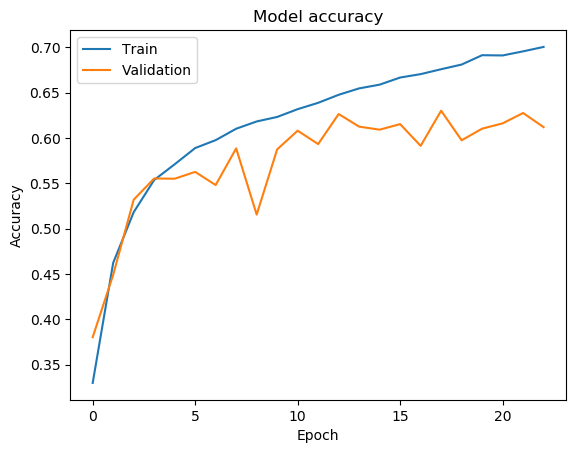

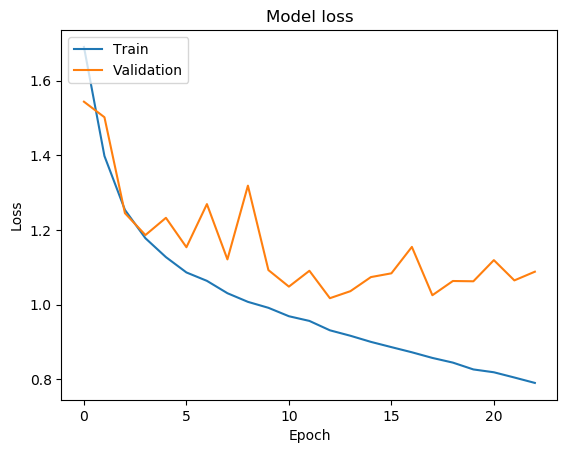

In [15]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluate Training and Test Performance

In [16]:
train_true = np.argmax(train_Y, axis=1)
train_pred = np.argmax(model.predict(train_X), axis=1)
print("CNN Model Accuracy on train set: {:.4f}".format(accuracy_score(train_true, train_pred)))

CNN Model Accuracy on train set: 0.6761


In [17]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6333


## More Analysis using Confusion Matrix

Confusion Matrix is applied and plotted to find out which emotion usually get confused with each other.

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Training Confusion Matrix

In [19]:
train_cm = confusion_matrix(train_true, train_pred)
print("Training confusion Matrix")
print(train_cm)


Training confusion Matrix
[[2338    2  200  257  670   91  437]
 [ 195  115   28   18   59    8   13]
 [ 535    4 1606  249  881  479  343]
 [  95    0   52 6703   98   92  175]
 [ 337    3  418  310 3144   60  558]
 [  83    2  205  237   44 2551   49]
 [ 185    0  145  586 1010   86 2953]]


In [20]:
#classification Report
print('Classification Report')
target_names = emotion_labels #list(class_labels.values())
print(classification_report(train_true, train_pred, target_names=target_names))


Classification Report
              precision    recall  f1-score   support

       Angry       0.62      0.59      0.60      3995
     Disgust       0.91      0.26      0.41       436
        Fear       0.61      0.39      0.48      4097
       Happy       0.80      0.93      0.86      7215
         Sad       0.53      0.65      0.59      4830
    Surprise       0.76      0.80      0.78      3171
     Neutral       0.65      0.59      0.62      4965

    accuracy                           0.68     28709
   macro avg       0.70      0.60      0.62     28709
weighted avg       0.67      0.68      0.67     28709



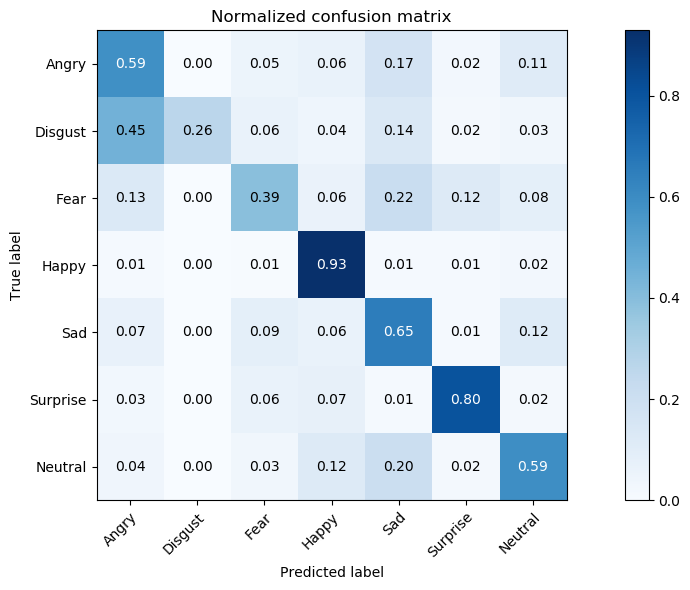

In [21]:
# Plot normalized confusion matrix
plot_confusion_matrix(train_true, train_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

Test confusion amatrix

In [22]:
test_cm = confusion_matrix(test_true, test_pred)
print("Test confusion Matrix")
print(test_cm)

Test confusion Matrix
[[271   1  27  32 101  14  45]
 [ 30  12   2   2   5   2   2]
 [ 88   1 179  32 117  75  36]
 [ 19   0   7 795  28  14  16]
 [ 45   0  66  58 328   6  91]
 [ 12   0  33  28  11 323   9]
 [ 22   0  21  62 147   9 365]]


In [23]:
#classification Report
print('Classification Report')
target_names = emotion_labels #list(class_labels.values())
print(classification_report(test_true, test_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Angry       0.56      0.55      0.55       491
     Disgust       0.86      0.22      0.35        55
        Fear       0.53      0.34      0.41       528
       Happy       0.79      0.90      0.84       879
         Sad       0.45      0.55      0.49       594
    Surprise       0.73      0.78      0.75       416
     Neutral       0.65      0.58      0.61       626

    accuracy                           0.63      3589
   macro avg       0.65      0.56      0.57      3589
weighted avg       0.63      0.63      0.62      3589



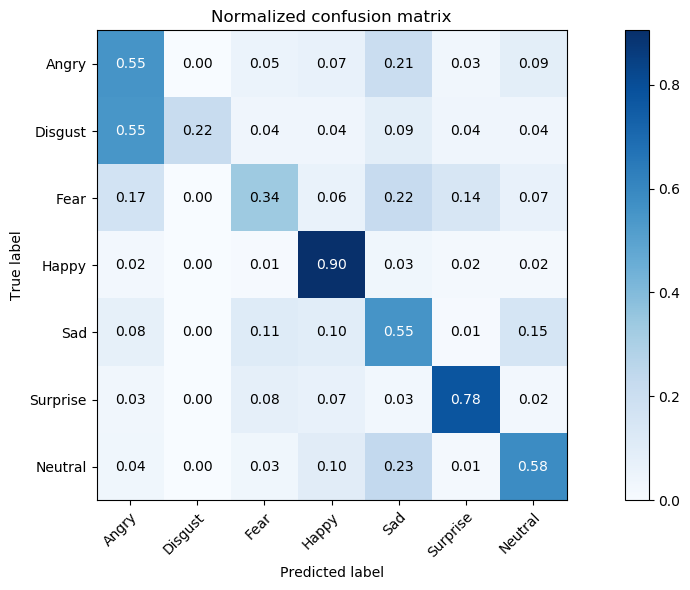

In [24]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()